In [21]:
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# torch.multiprocessing.set_start_method('spawn')
import gym_lite6.env, gym_lite6.pickup_task, gym_lite6.utils, gym_lite6.models
%env MUJOCO_GL=egl # Had to export this before starting jupyter server
# import mujoco

from importlib import reload
import gym_lite6.models.mlp
reload(gym_lite6.models.mlp)

env: MUJOCO_GL=egl # Had to export this before starting jupyter server


<module 'gym_lite6.models.mlp' from '/media/ssd/eugene/robotic_manipulation/gym_lite6/gym_lite6/models/mlp.py'>

In [22]:

checkpoint = torch.load("BC-MLP-MSE/ckpts/lite6_grasp_h64_64_64_2024-09-02_00-11-31/epoch_20.pt")
start_epoch = checkpoint["epoch"]
step = checkpoint["step"]
params = checkpoint["params"]

params["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy = gym_lite6.models.mlp.MLPPolicy([64, 64, 64]).to(params["device"])
policy.eval()
policy.load_state_dict(checkpoint["policy_state_dict"])

print(f"Loaded checkpoint at epoch {start_epoch}")

Loaded checkpoint at epoch 20


""

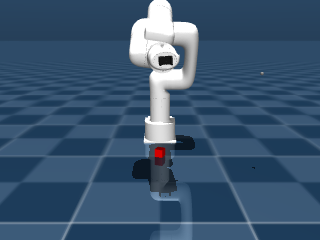

In [32]:
task = gym_lite6.pickup_task.GraspTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=150,
    visualization_width=320,
    visualization_height=240
)
qpos0 = np.array([0, 0.541, 1.49 , 2.961, 0.596, 0.203])
box_pos0 = np.array([0.2, 0, 0.0])
box_quat0 = None
observation, info = env.reset(qpos=qpos0, box_pos=box_pos0, box_quat=box_quat0)
media.show_image(env.unwrapped.render(camera="side_cam"))

{'normalize_qpos': True, 'joint_bounds': {'centre': tensor([0.0000, 0.0000, 2.5875, 0.0000, 0.0000, 0.0000]), 'range': tensor([12.5664,  5.2360,  5.2971, 12.5664,  4.3284, 12.5664])}, 'device': device(type='cuda')}
Average reward: 0.0


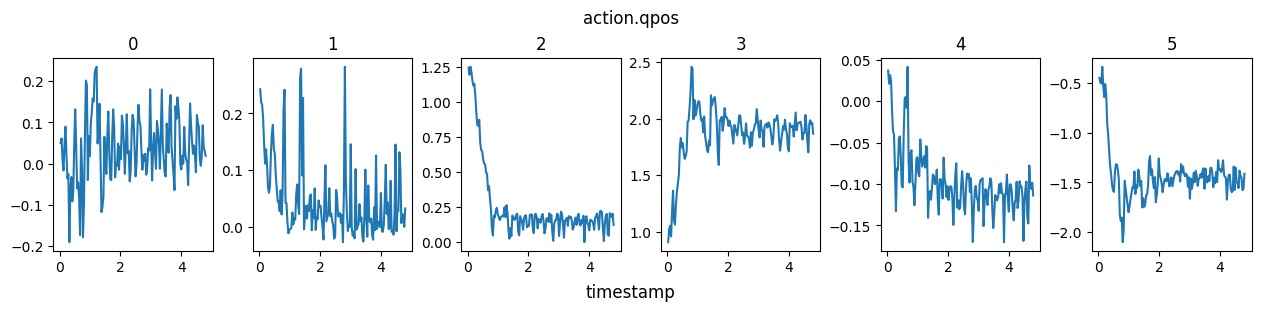

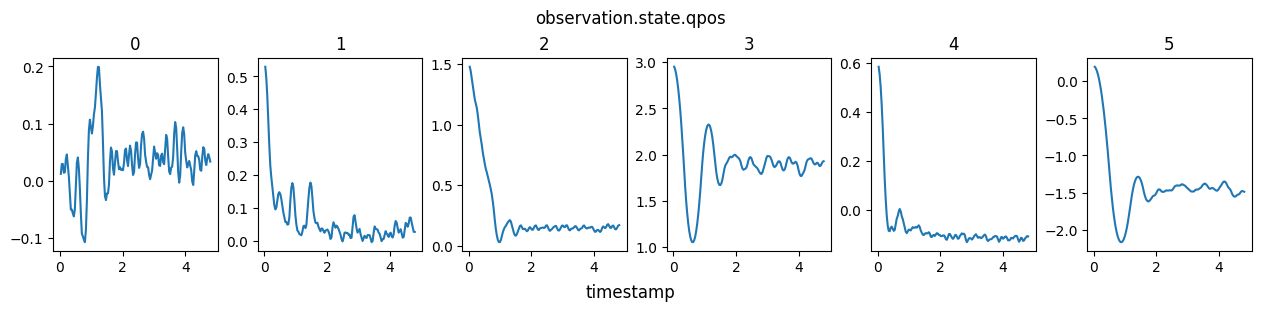

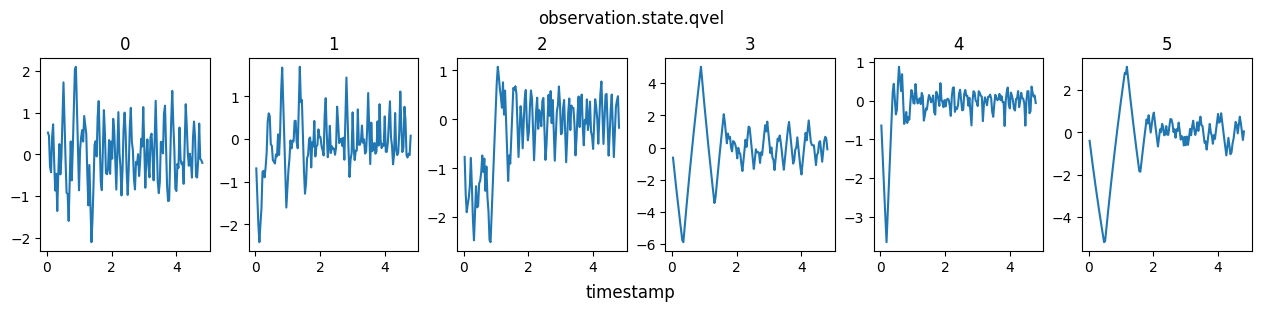

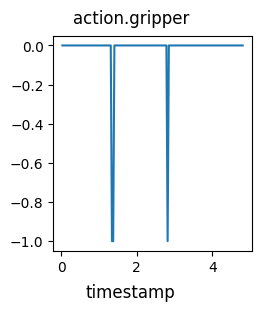

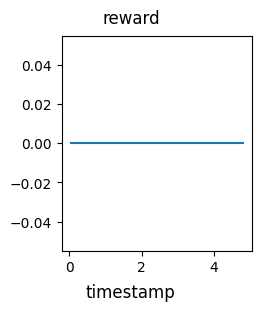

In [33]:
trainer = gym_lite6.models.mlp.Interface(params)
avg_reward = 0
observation, info = env.reset(qpos=qpos0, box_pos=box_pos0, box_quat=box_quat0)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []
action = {}

ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

# Render frame of the initial state
frames.append(env.render())

step = 0
done = False
# Will get truncated at max_episode_steps
while not done:
  # Prepare observation for the policy running in Pytorch
  # Get qpos in range (-1, 1), gripper is already in range (-1, 1)
  qpos = torch.from_numpy(observation["state"]["qpos"]).unsqueeze(0)
  gripper = trainer.embed_gripper(torch.tensor(observation["state"]["gripper"])).unsqueeze(0)
  if trainer.params["normalize_qpos"]:
    qpos = trainer.normalize_qpos(qpos)
  state = torch.hstack((qpos, gripper))
  image_side = torch.from_numpy(observation["pixels"]["side"]).permute(2, 0, 1).unsqueeze(0) / 255
  image_gripper = torch.from_numpy(observation["pixels"]["gripper"]).permute(2, 0, 1).unsqueeze(0) / 255
  
  # Convert to float32 with image from channel first in [0,255]
  # to channel last in [0,1]
  state = state.to(torch.float32)

  # Send data tensors from CPU to GPU
  state = state.to(trainer.params["device"], non_blocking=True)
  image_side = image_side.to(trainer.params["device"], non_blocking=True)
  image_gripper = image_gripper.to(trainer.params["device"], non_blocking=True)

  # Predict the next action with respect to the current observation
  with torch.inference_mode():
    raw_action = policy.predict(state, image_side, image_gripper).to("cpu")
  
  action["qpos"] = raw_action[:, :6]
  if trainer.params["normalize_qpos"]:
    action["qpos"] = trainer.unnormalize_qpos(action["qpos"])
  
  action["qpos"] = action["qpos"].flatten().numpy()
  action["gripper"] = trainer.decode_gripper(raw_action[:, 6:8]).item()

  # Step through the environment and receive a new observation
  observation, reward, terminated, truncated, info = env.step(action)
  # Keep track of all the rewards and frames
  rewards.append(reward)
  frames.append(env.render())

  ep_dict["action.qpos"].append(action["qpos"])
  ep_dict["action.gripper"].append(action["gripper"])
  ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
  ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
  ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
  ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
  ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
  ep_dict["reward"].append(reward)
  ep_dict["timestamp"].append(env.unwrapped.data.time)
  ep_dict["frame_index"].append(step)

  # The rollout is considered done when the success state is reach (i.e. terminated is True),
  # or the maximum number of iterations is reached (i.e. truncated is True)
  done = terminated | truncated | done
  step += 1

avg_reward = np.mean(rewards)
print(params)
print(f"Average reward: {avg_reward}")
media.show_videos([ep_dict["observation.pixels.side"], ep_dict["observation.pixels.gripper"]], fps=env.metadata["render_fps"])
gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "action.gripper", "reward"], sharey=False)



In [17]:
avg_reward = np.mean(rewards)
